In [317]:
import pandas as pd
import yfinance as yf

# Download historical stock data
tckr = str(input("Enter your Ticker: "))
tckr = tckr.upper()
df = yf.download(tckr, start='2020-01-01', end='2025-12-31')

# Keep only relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [318]:
# Predict the next day's closing price
df['Next_High'] = df['High'].shift(-1).fillna(df['Close'])

# Define features and target
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Next_High']

In [319]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [320]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [321]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a simple feedforward neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

c:\Users\genas\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [322]:
# Early stopping to prevent overfitting
# ReduceLROnPlateau to adapt the learning rate dynamically
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 145992.1094 - val_loss: 235553.8594 - learning_rate: 0.0010
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 140647.2969 - val_loss: 225465.8750 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118679.5234 - val_loss: 189411.0781 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74193.8047 - val_loss: 125084.9609 - learning_rate: 0.0010
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52735.7695 - val_loss: 52830.6016 - learning_rate: 0.0010
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31281.5312 - val_loss: 4803.9180 - learning_rate: 0.0010
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15891.5322 - val_loss: 17199.1680 - learning_rate: 0.0010
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8223.7129 - val_loss: 27034.9395 - learning_rate: 0.0010
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

In [323]:
import matplotlib.pyplot as plt
import numpy as np

# R² compares your model to a baseline model that always predicts the mean.
# If R² is close to 1, your model is capturing most of the trend in the data.
# If R² is 0, your model is no better than guessing the average.
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")  # Target: > 0.75



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
R² Score: -38.3705


In [324]:
import os
from datetime import datetime

# Get the last date
last_index = y_test.tail(1).index[0]

# Convert predictions to Series if needed
if not isinstance(y_pred, pd.Series):
    y_pred = pd.Series(y_pred.flatten(), index=y_test.index)

save_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'''
# Create a DataFrame with true, predicted, and timestamp
result_df = pd.DataFrame({
    'Ticker': [tckr] * len(y_test),
    'Actual': y_test.values,
    'Predicted': y_pred.values,
    'Saved': [save_time] * len(y_test),
    'R2 Score': [r2] * len(y_test),
}, index=y_test.index)

'''

# Create a single-row DataFrame for the latest prediction
result_df = pd.DataFrame({
    'Ticker': [tckr],
    'Actual': [y_test.loc[last_index]],
    'Predicted': [y_pred.loc[last_index]],
    'R2 Score': [r2],
    'Saved': [save_time]
}, index=[last_index])

# Reset index and rename as 'Date'
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'Date'}, inplace=True)

# Define path
csv_path = 'predictions_log.csv'

# Check if file exists
if os.path.exists(csv_path):
    # Append to the existing file
    result_df.to_csv(csv_path, mode='a', header=False, index=False)
else:
    # Create a new file with headers
    result_df.to_csv(csv_path, mode='w', header=True, index=False)

print(f"✅ Results saved to {csv_path} at {save_time}")

✅ Results saved to predictions_log.csv at 2025-06-03 11:53:23


In [325]:
y_test

Date
2024-05-01    499.532191
2024-05-02    506.108494
2024-05-03    510.117479
2024-05-06    512.052860
2024-05-07    511.233200
                 ...    
2025-05-28    593.200012
2025-05-29    591.130005
2025-05-30    592.789978
2025-06-02    597.080017
2025-06-03    596.169983
Name: Next_High, Length: 273, dtype: float64

In [326]:
y_pred

Date
2024-05-01    452.783020
2024-05-02    480.951111
2024-05-03    488.918396
2024-05-06    543.817139
2024-05-07    541.178284
                 ...    
2025-05-28    799.300415
2025-05-29    800.975769
2025-05-30    782.093445
2025-06-02    803.013123
2025-06-03    838.981262
Length: 273, dtype: float32

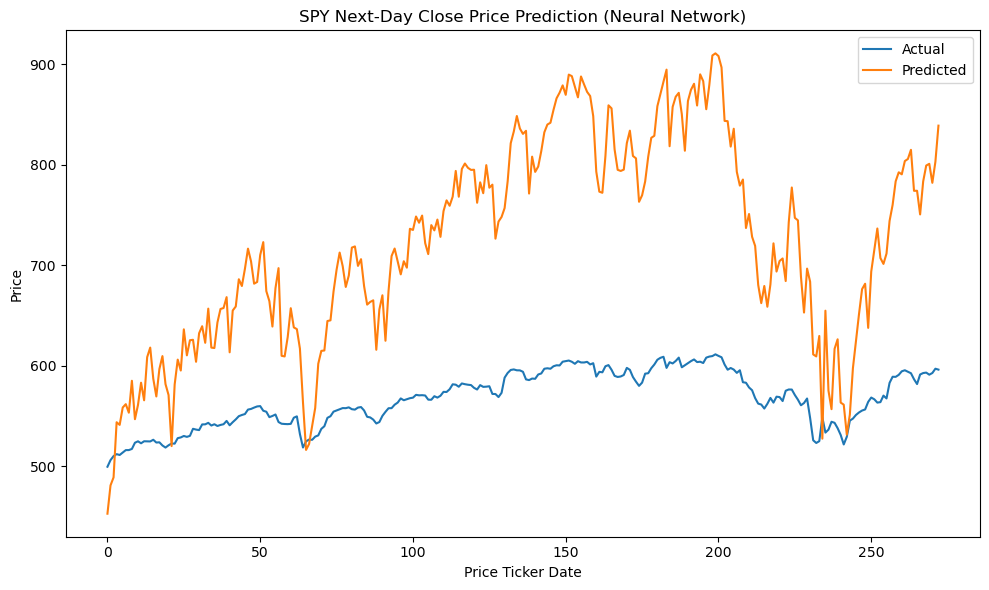

In [327]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test.values, label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted')
plt.title(f'{tckr} Next-Day Close Price Prediction (Neural Network)')
plt.xlabel('Price Ticker Date') #('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

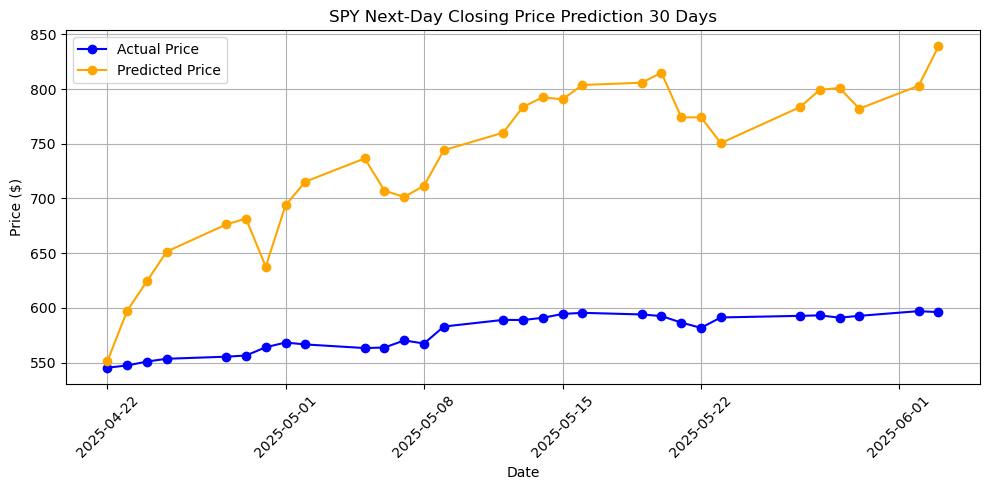

In [328]:
# Extract last 5 days of test predictions and actuals
last_n = 30
y_test_last = y_test[-last_n:]
y_pred_last = y_pred[-last_n:]

# Extract corresponding dates
if isinstance(y_test.index, pd.DatetimeIndex):
    test_dates = y_test.index[-last_n:]
else:
    # fallback if index is not datetime (e.g., RangeIndex)
    test_dates = pd.date_range(end=pd.Timestamp.today(), periods=last_n)

# Plot last week only
plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_last.values, label='Actual Price', marker='o', color='blue')
plt.plot(test_dates, y_pred_last, label='Predicted Price', marker='o', color='orange')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{tckr} Next-Day Closing Price Prediction {last_n} Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [329]:
df

Price,Open,High,Low,Close,Volume,Next_High
Ticker,SPY,SPY,SPY,SPY,SPY,
Date,,,,,,
2020-01-02,299.062291,300.310161,298.128695,300.291656,59151200,299.154653
2020-01-03,296.862270,299.154653,296.806812,298.017700,77709700,299.237820
2020-01-06,296.242927,299.237820,296.122758,299.154633,55653900,299.062162
2020-01-07,298.581485,299.062162,297.860498,298.313446,40496400,301.132685
2020-01-08,298.507552,301.132685,298.257990,299.903320,68296000,302.010822
...,...,...,...,...,...,...
2025-05-28,591.559998,592.770020,586.989990,587.729980,68445500,593.200012
2025-05-29,593.059998,593.200012,586.070007,590.049988,69973300,591.130005


In [330]:
# Load the CSV into a DataFrame
df_log = pd.read_csv(csv_path)

# Ensure 'Saved' column is parsed as datetime
df_log['Saved'] = pd.to_datetime(df_log['Saved'])

# Filter by ticker and sort by Saved in descending order
filtered_df = df_log[df_log['Ticker'] == tckr].sort_values(by='Saved', ascending=False)

# Display result
filtered_df

,Date,Ticker,Actual,Predicted,R2 Score,Saved
22,2025-06-03,SPY,596.169983,838.98126,-38.370482,2025-06-03 11:53:23
18,2025-06-03,SPY,596.329895,641.34860,-0.692911,2025-06-03 11:43:00
14,2025-06-03,SPY,596.005005,653.50280,-1.977109,2025-06-03 11:28:13
10,2025-06-03,SPY,595.044983,897.60020,-59.095534,2025-06-03 11:17:36
6,2025-06-03,SPY,596.140015,639.26636,-0.623866,2025-06-03 10:59:56


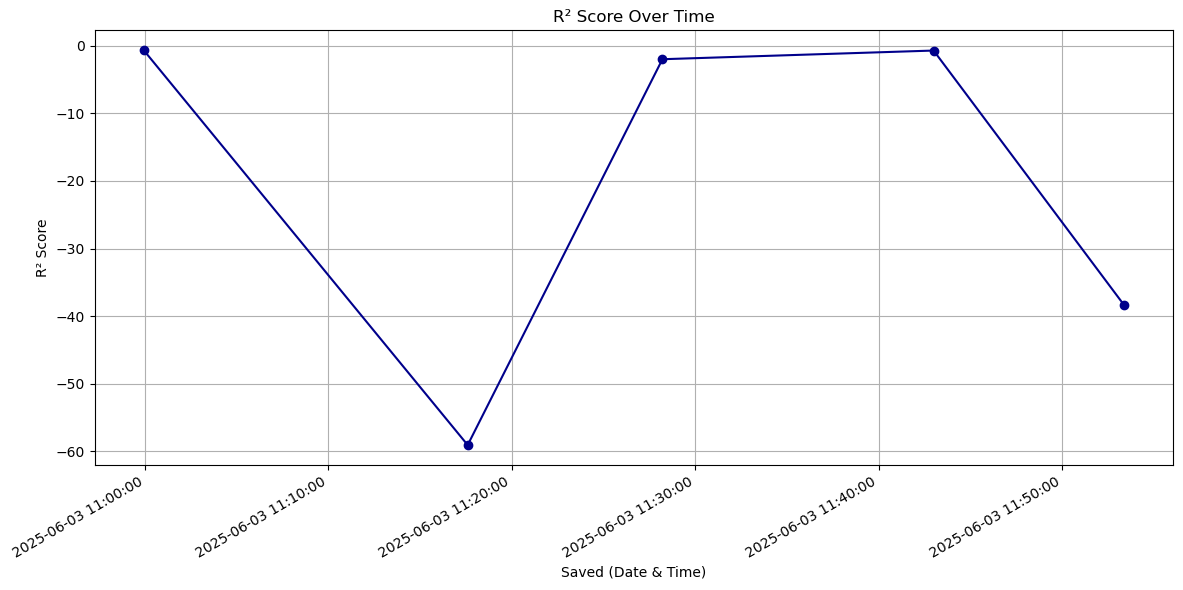

In [331]:
import matplotlib.dates as mdates

# Convert 'Saved' to datetime
filtered_df['Saved'] = pd.to_datetime(filtered_df['Saved'])

# Plot R² Score over time
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Saved'], filtered_df['R2 Score'], marker='o', linestyle='-', color='darkblue')

# Formatting full datetime on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels

# Labels and title
plt.xlabel('Saved (Date & Time)')
plt.ylabel('R² Score')
plt.title('R² Score Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()